### Autogen

In [autogen](https://github.com/microsoft/autogen) I didn't success to make any web-browsing system, either with the [built-in example from the doc](https://microsoft.github.io/autogen/0.2/docs/notebooks/agentchat_groupchat_research/), or a multi-agent system with a [custom tool](https://microsoft.github.io/autogen/0.2/docs/tutorial/tool-use/).

In [ ]:
import autogen
import os
from dotenv import load_dotenv

load_dotenv()
config_list_gpt4 = [{"model": "gpt-4", "api_key": os.environ["OPENAI_API_KEY"]}]

In [ ]:
# This is equivalent to:
# from transformers.agents import DuckDuckGoSearchTool


def search(query: str) -> str:
    try:
        from duckduckgo_search import DDGS
    except ImportError:
        raise ImportError(
            "You must install package `duckduckgo_search` to run this tool: for instance run `pip install duckduckgo-search`."
        )
    results = DDGS().text(query, max_results=7)
    return results

In [10]:
gpt4_config = {
    "cache_seed": 42,  # change the cache_seed for different trials
    "temperature": 0,
    "config_list": config_list_gpt4,
    "timeout": 120,
}
# This one often causes the code to run on infinite loop of asking the admin his opinion
user_proxy = autogen.UserProxyAgent(
    name="Admin",
    system_message="A human admin.",
    code_execution_config=False,
)
engineer = autogen.AssistantAgent(
    name="Engineer",
    llm_config=gpt4_config,
    system_message="""Engineer. You follow an approved plan. You write python/shell code to solve tasks. Wrap the code in a code block that specifies the script type. The user can't modify your code. So do not suggest incomplete code which requires others to modify. Don't use a code block if it's not intended to be executed by the executor.
Don't include multiple code blocks in one response. Do not ask others to copy and paste the result. Check the execution result returned by the executor.
If the result indicates there is an error, fix the error and output the code again. Suggest the full code instead of partial code or code changes. If the error can't be fixed or if the task is not solved even after the code is executed successfully, analyze the problem, revisit your assumption, collect additional info you need, and think of a different approach to try.
""",
)
websearch = autogen.AssistantAgent(
    name="Web searcher",
    llm_config=gpt4_config,
    system_message="""Web searcher.You can search the web to find papers. You don't write code.""",
)
# websearch.register_for_llm(name="search", description="A simple google search")(search)

# # Why should we need this second line? Strange
# user_proxy.register_for_execution(name="search")(search)

# Since the above two lines didn'y work, let's try another way from the doc
from autogen import register_function

register_function(
    search,
    caller=websearch,  # The assistant agent can suggest calls to the calculator.
    executor=user_proxy,  # The user proxy agent can execute the calculator calls.
    name="search",  # By default, the function name is used as the tool name.
    description="A simple google search",  # A description of the tool.
)


executor = autogen.UserProxyAgent(
    name="Executor",
    system_message="Executor. Execute the code written by the engineer and report the result.",
    human_input_mode="NEVER",
    code_execution_config={
        "last_n_messages": 3,
        "work_dir": "paper",
        "use_docker": False,
    },  # Please set use_docker=True if docker is available to run the generated code. Using docker is safer than running the generated code directly.
)

groupchat = autogen.GroupChat(
    agents=[engineer, executor, websearch], messages=[], max_round=50
)
manager = autogen.GroupChatManager(groupchat=groupchat, llm_config=gpt4_config)

In [11]:
user_proxy.function_map

{'search': <function __main__.search(query: str) -> str>}

In [12]:
user_proxy.initiate_chat(
    manager,
    message="""
What's the current age of the Pope, power 0.82? Use web search first
""",
)

Admin (to chat_manager):


What's the current age of the Pope, power 0.82? Use web search first


--------------------------------------------------------------------------------

Next speaker: Web searcher

Web searcher (to chat_manager):

***** Suggested tool call (call_w2JoVM3ewqFZhad5enewHwkz): search *****
Arguments: 
{
  "query": "current age of the Pope"
}
***********************************************************************

--------------------------------------------------------------------------------


ValueError: No agent can execute the function search. Please check the function_map of the agents.

### Execution feedback

This quickly became a shitshow, with many turns spent in vain while the manager agent (of which we don't see the decisions) misallocating next turns to various members of the team.
```bash
--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

I apologize for the confusion. It seems that the `feedparser` library is also not available in this environment. 

Unfortunately, without the ability to install additional libraries, we are limited in our ability to interact with the Arxiv API or RSS feed directly from this environment.

However, I can provide a Python script that you can run in your local environment to fetch the papers from Arxiv and create a markdown table. You will need to install the `arxiv` and `pandas` libraries to run this script.

Here is the script:

```python
import arxiv
import pandas as pd
import datetime

# Define the search query
query = "all:LLM"

# Define the time range (last week)
start_time = datetime.datetime.now() - datetime.timedelta(weeks=1)
start_time_str = start_time.strftime("%Y%m%d%H%M%S")

# Fetch the papers
papers = arxiv.Search(
    query=query,
    sort_by=arxiv.SortCriterion.SubmittedDate,
    sort_order=arxiv.SortOrder.Descending,
    start_time=start_time_str
).results()

# Create a DataFrame to store the papers
df = pd.DataFrame(columns=["Title", "Authors", "Summary", "URL"])

# Add the papers to the DataFrame
for paper in papers:
    df = df.append({
        "Title": paper.title,
        "Authors": ', '.join(author.name for author in paper.authors),
        "Summary": paper.summary,
        "URL": paper.entry_id
    }, ignore_index=True)

# Convert the DataFrame to a markdown table
markdown_table = df.to_markdown()

# Print the markdown table
print(markdown_table)
```

To run this script, you will need to install the `arxiv` and `pandas` libraries. You can do this by running `pip install arxiv pandas` in your command line.

--------------------------------------------------------------------------------

Next speaker: Scientist

Scientist (to chat_manager):

I'm sorry for the confusion, but as a text-based AI model, I don't have the ability to install packages or run scripts in a local environment. However, I can guide you on how to do it.

Here's how you can run the script provided by the Engineer:

1. Open a terminal on your computer.

2. If you don't have Python installed, download and install it from the official website: https://www.python.org/downloads/

3. Install the `arxiv` and `pandas` libraries by running the following command in your terminal:
   ```
   pip install arxiv pandas
   ```

4. Create a new Python file (for example, `fetch_papers.py`) and copy the script into this file.

5. Run the script by running the following command in your terminal:
   ```
   python fetch_papers.py
   ```

The script will print a markdown table of the papers on LLM applications published in the last week. The table will have columns for the title, authors, summary, and URL of each paper.

--------------------------------------------------------------------------------

Next speaker: Critic

Critic (to chat_manager):

The plan and the code provided by the Engineer and Scientist are correct. However, it's important to note that the code can't be executed in this environment due to the lack of necessary libraries. The Scientist has provided a detailed guide on how to run the script in a local environment. Please follow these instructions to execute the script.

--------------------------------------------------------------------------------

Next speaker: Admin


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
Admin (to chat_manager):



--------------------------------------------------------------------------------

Next speaker: Scientist

Scientist (to chat_manager):

As an AI model, I don't have the ability to execute scripts or install packages. However, I can provide guidance and instructions. Please follow the steps provided by the Scientist to run the script in your local environment.

--------------------------------------------------------------------------------

Next speaker: Admin


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
Admin (to chat_manager):



--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

I apologize for the confusion. As an AI model, I don't have the ability to execute scripts or install packages. However, I can provide guidance and instructions. Please follow the steps provided by the Scientist to run the script in your local environment.

--------------------------------------------------------------------------------

Next speaker: Admin


>>>>>>>> NO HUMAN INPUT RECEIVED.

>>>>>>>> USING AUTO REPLY...
Admin (to chat_manager):



--------------------------------------------------------------------------------

Next speaker: Scientist

Scientist (to chat_manager):

As an AI model, I don't have the ability to execute scripts or install packages. However, I can provide guidance and instructions. Please follow the steps provided by the Scientist to run the script in your local environment.

--------------------------------------------------------------------------------

Next speaker: Engineer

Engineer (to chat_manager):

As an AI model, I don't have the ability to execute scripts or install packages. However, I can provide guidance and instructions. Please follow the steps provided by the Scientist to run the script in your local environment.

--------------------------------------------------------------------------------

Next speaker: Critic

Critic (to chat_manager):

The plan and the code provided by the Engineer and Scientist are correct. However, it's important to note that the code can't be executed in this environment due to the lack of necessary libraries. The Scientist has provided a detailed guide on how to run the script in a local environment. Please follow these instructions to execute the script.

--------------------------------------------------------------------------------

Next speaker: Admin
```


### Second try

Let's simplify the team to make it more efficient.

I removed all agents except useful ones and tried to add the web search tool to them:
I get error: `ValueError: No agent can execute the function search. Please check the function_map of the agents.`

Although the function is well defined in the agent's `function_map`:

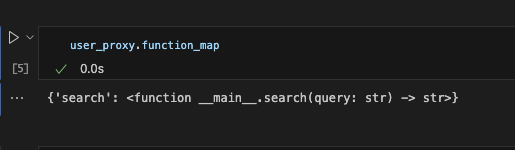

So the mystery continues. Anyway I've got some good ideas from autogen already.

In [ ]:
import os
from typing import Annotated, Literal

Operator = Literal["+", "-", "*", "/"]


def calculator(a: int, b: int, operator: Annotated[Operator, "operator"]) -> int:
    if operator == "+":
        return a + b
    elif operator == "-":
        return a - b
    elif operator == "*":
        return a * b
    elif operator == "/":
        return int(a / b)
    else:
        raise ValueError("Invalid operator")


from autogen import ConversableAgent

# Let's first define the assistant agent that suggests tool calls.
assistant = ConversableAgent(
    name="Assistant",
    system_message="You are a helpful AI assistant. "
    "You can help with simple calculations. "
    "Return 'TERMINATE' when the task is done.",
    llm_config={
        "config_list": [{"model": "gpt-4", "api_key": os.environ["OPENAI_API_KEY"]}]
    },
)

# The user proxy agent is used for interacting with the assistant agent
# and executes tool calls.
user_proxy = ConversableAgent(
    name="User",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None
    and "TERMINATE" in msg["content"],
    human_input_mode="NEVER",
)

# Register the tool signature with the assistant agent.
assistant.register_for_llm(name="calculator", description="A simple calculator")(
    calculator
)

# Register the tool function with the user proxy agent.
user_proxy.register_for_execution(name="calculator")(calculator)

user_proxy.function_map

{'calculator': <function __main__.calculator(a: int, b: int, operator: Annotated[Literal['+', '-', '*', '/'], 'operator']) -> int>}

In [ ]:
chat_result = user_proxy.initiate_chat(
    assistant, message="What is (44232 + 13312 / (232 - 32)) * 5?"
)

User (to Assistant):

What is (44232 + 13312 / (232 - 32)) * 5?

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_v7VMeSzM5RWZ6XHXWK3zu6ou): calculator *****
Arguments: 
{
  "a": 232,
  "b": 32,
  "operator": "-"
}
***************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION calculator...
User (to Assistant):

***** Response from calling tool (call_v7VMeSzM5RWZ6XHXWK3zu6ou) *****
200
**********************************************************************

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_npRmhUCUfgMFNCG9c8Gwz9A7): calculator *****
Arguments: 
{
  "a": 13312,
  "b": 200,
  "operator": "/"
}
******************************